In [1]:
from sklearn.metrics import classification_report, confusion_matrix
from skimage.metrics import structural_similarity as ssim
from sklearn import preprocessing
from keras.utils import to_categorical
from keras import regularizers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.src.legacy.preprocessing.image import ImageDataGenerator

import random
import re
import glob
from tqdm import tqdm
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import gc

2025-02-17 12:14:51.442240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 12:14:51.524993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 12:14:51.564970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 12:14:52.352391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def apply_fourier_transform(image_path, output_dir="output_images"):
# Criar diretório de saída se não existir
    os.makedirs(output_dir, exist_ok=True)
    
# Carregar a imagem em escala de cinza
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Imagem não encontrada ou caminho inválido.")
    
# Aplicar a Transformada de Fourier
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    
# Gerar um limiar aleatório para separar baixas e altas frequências
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    threshold = random.randint(10, min(crow, ccol))
    print(f"Limiar escolhido para separação de frequências: {threshold}")
    
# Máscara para baixas frequências
    mask_low = np.zeros((rows, cols), np.uint8)
    mask_low[crow-threshold:crow+threshold, ccol-threshold:ccol+threshold] = 1
    
# Máscara para altas frequências
    mask_high = 1 - mask_low
    
# Aplicar máscaras
    fshift_low = fshift * mask_low
    fshift_high = fshift * mask_high
    
# Espectro de magnitude das frequências baixas e altas
    magnitude_spectrum_low = 20 * np.log(np.abs(fshift_low) + 1)
    magnitude_spectrum_high = 20 * np.log(np.abs(fshift_high) + 1)
    
# Transformada inversa para obter imagens de baixas e altas frequências
    img_back_low = np.fft.ifft2(np.fft.ifftshift(fshift_low))
    img_back_low = np.abs(img_back_low)
    
    img_back_high = np.fft.ifft2(np.fft.ifftshift(fshift_high))
    img_back_high = np.abs(img_back_high)
    
# Normalizar as imagens para o intervalo [0, 255]
    img_back_low = cv2.normalize(img_back_low, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    img_back_high = cv2.normalize(img_back_high, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
# Caminhos dos arquivos salvos
    img_low_path = os.path.join(output_dir, "frequencias_baixas.png")
    img_high_path = os.path.join(output_dir, "frequencias_altas.png")
    spectrum_low_path = os.path.join(output_dir, "espectro_baixas.png")
    spectrum_high_path = os.path.join(output_dir, "espectro_altas.png")
    original_path = os.path.join(output_dir, "imagem_original.png")
    spectrum_original_path = os.path.join(output_dir, "espectro_original.png")
    
# Salvar as imagens no diretório
    cv2.imwrite(img_low_path, img_back_low)
    cv2.imwrite(img_high_path, img_back_high)
    cv2.imwrite(spectrum_low_path, magnitude_spectrum_low)
    cv2.imwrite(spectrum_high_path, magnitude_spectrum_high)
    cv2.imwrite(original_path, image)
    cv2.imwrite(spectrum_original_path, magnitude_spectrum)
    
    print(f"Imagens salvas em: {output_dir}")
    
# Exibir as imagens
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.title("Imagem Original")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 3, 4)
    plt.title("Espectro Original")
    plt.imshow(magnitude_spectrum, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 3, 2)
    plt.title("Frequências Baixas")
    plt.imshow(img_back_low, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 3, 5)
    plt.title("Espectro Baixas Frequências")
    plt.imshow(magnitude_spectrum_low, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 3, 3)
    plt.title("Frequências Altas")
    plt.imshow(img_back_high, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 3, 6)
    plt.title("Espectro Altas Frequências")
    plt.imshow(magnitude_spectrum_high, cmap="gray")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return img_back_low, img_back_high

Limiar escolhido para separação de frequências: 395
Imagens salvas em: output_images


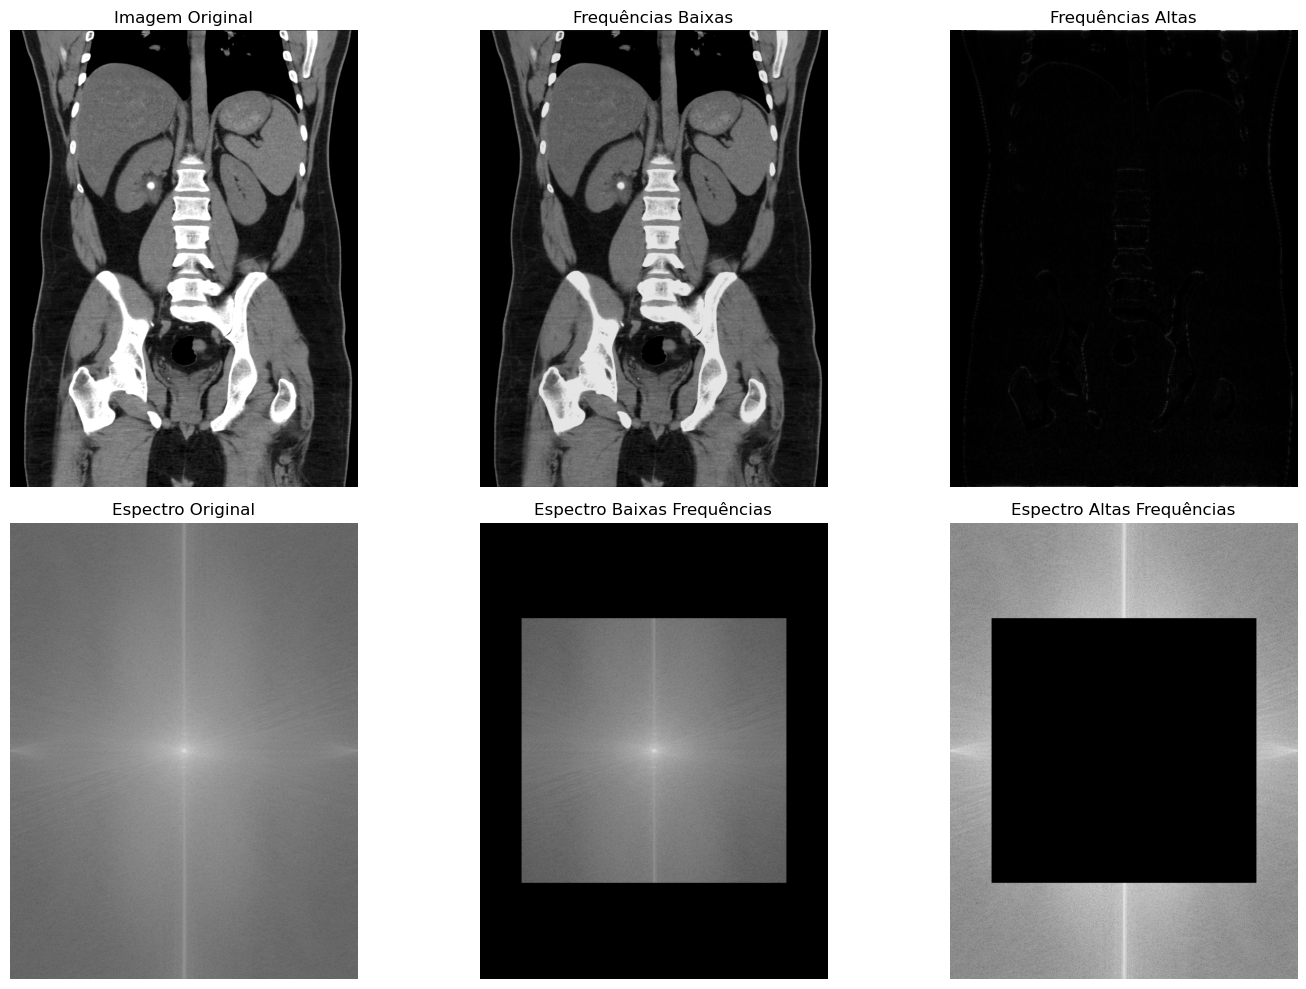

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

In [3]:
apply_fourier_transform('Bases/DatasetYildirim/Train/Kidney_stone/1.3.46.670589.33.1.63700700749865510700001.5062181202000819812.png')